In [154]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

from math import sqrt
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/matthew/git/cadc_testing/uncertainty_eval


In [170]:
datasets = ['KITTI', 'CADC', 'NuScenes']
data_set_mode = datasets[0]
NETWORK_VAR_AVAILABLE = True
logdir = '/home/matthew/git/cadc_testing/pcdet_output/output_pkls'

if data_set_mode == 'KITTI':
    dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/kitti'
    preds_path = os.path.join(logdir, 'kitti/pp_mimo_a.pkl')
#     preds_path = os.path.join(logdir, 'kitti/pp_mimo_c.pkl')
#     preds_path = os.path.join(logdir, 'kitti/pp_mimo_c_input_blank.pkl')
#     preds_path = os.path.join(logdir, 'kitti/pp_mimo_c_blank_input.pkl')
#     preds_path = os.path.join(logdir, 'kitti/pp_ensemble.pkl')
    gts_path = os.path.join(logdir, 'kitti_infos_val.pkl')
#     gts_path = os.path.join(logdir, 'kitti_infos_train.pkl')
elif data_set_mode == 'CADC':
    dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/cadc'
    preds_path = os.path.join(logdir, 'cadc_pp_baseline.pkl')
    gts_path = os.path.join(logdir, 'cadc_infos_val.pkl')
#     gts_path = os.path.join(logdir, 'cadc_infos_train.pkl')
elif data_set_mode == 'NuScenes':
    dataset_path = '/run/user/1000/gvfs/sftp:host=wisebob.eng.uwaterloo.ca,user=mapitrop/data/NuScenes/v1.0-trainval'
    preds_path = os.path.join(logdir, 'nuscenes/nuscenes_pp_baseline_20pc.pkl')
#     preds_path = os.path.join(logdir, 'nuscenes/nuscenes_pp_mimo_c.pkl')
    gts_path = os.path.join(logdir, 'nuscenes/nuscenes_infos_10sweeps_val.pkl')
#     gts_path = os.path.join(logdir, 'nuscenes/nuscenes_infos_10sweeps_train.pkl')

In [207]:
def load_dicts():
    # Load gt and prediction data dict
    with open(gts_path, 'rb') as f:
        gt_dicts = pickle.load(f)
    with open(preds_path, 'rb') as f:
        pred_dicts = pickle.load(f)
    return gt_dicts, pred_dicts

def load_image(frame_id):
    img_path = os.path.join(dataset_path, 'training', 'image_2', f'{frame_id}.png')
    return plt.imread(img_path)

def load_lidar(frame_id, xlim, ylim):
    lidar_path = os.path.join(dataset_path, 'training', 'velodyne', f'{frame_id}.bin')
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask]
    return points

def load_image_cadc(sample_idx):
    date, set_num, idx = sample_idx
    img_path = os.path.join(dataset_path, date, set_num, 'labeled', 'image_00', 'data', '%s.png' % idx)
    return plt.imread(img_path)

def load_lidar_cadc(sample_idx, xlim, ylim):
    date, set_num, idx = sample_idx
    lidar_file = os.path.join(dataset_path, date, set_num, 'labeled', 'lidar_points', 'data', '%s.bin' % idx)
    points =  np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask]
    return points

def load_lidar_nuscenes(lidar_path, xlim, ylim):
    lidar_file = os.path.join(dataset_path, lidar_path)
    points =  np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 5)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask][...,:4]
    return points

def add_box(ax, box, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    h = box[4]
    xy = (box[0] - w/2, box[1] - h/2)
    angle = box[-1] * 180 / np.pi
    box_rect = Rectangle(
        xy, w, h, facecolor='none', edgecolor=color
    )
    t = Affine2D().rotate_around(box[0], box[1], box[-1]) + ax.transData
    box_rect.set_transform(t)
    ax.add_patch(box_rect)

def add_box_vars(ax, box, box_vars, cluster_size, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    sigma_w = sqrt(box_vars[3])
    h = box[4]
    sigma_h = sqrt(box_vars[4])
    # Confidence interval caluculations
    z_score = 1.96 # 95% CI
    w += z_score * sigma_w / sqrt(cluster_size)
    h += z_score * sigma_h / sqrt(cluster_size)
    xy = (box[0] - w/2, box[1] - h/2)
    angle = box[-1] * 180 / np.pi
    box_rect = Rectangle(
        xy, w, h, facecolor='tab:gray', edgecolor='tab:gray', alpha=0.5
    )
    t = Affine2D().rotate_around(box[0], box[1], box[-1]) + ax.transData
    box_rect.set_transform(t)
    ax.add_patch(box_rect)
    
def add_text(ax, box, cluster_size, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    h = box[4]
    xy = (box[0] + w/2, box[1] + h/2)
    ax.text(xy[0], xy[1], cluster_size, color=color, backgroundcolor='white', fontsize=8, fontweight='bold')

In [172]:
# Load example GT and prediction
idx = np.random.randint(3700)
# idx = 2322, 291
idx = 0
print(idx)
gt_dicts, pred_dicts = load_dicts()

print('Example GT dict:')
print(gt_dicts[idx].keys())
print('Example pred dict:')
if NETWORK_VAR_AVAILABLE:
    print(pred_dicts[idx][0].keys())
    print(len(pred_dicts[idx]))
    print(len(pred_dicts[1][0]['name']) * 2)
    print(pred_dicts[0][0]['name'])
    print(len(pred_dicts[0][0]['name']))
    print(pred_dicts[0][0]['score'])
    print(len(pred_dicts[1][0]['name']))
    print(pred_dicts[1][0]['score'])
else:
    print(pred_dicts[idx].keys())
    print(len(pred_dicts[idx]))
    print(len(pred_dicts[1]['name']) * 2)
    print(pred_dicts[0]['name'])
    print(len(pred_dicts[0]['name']))
    print(pred_dicts[0]['score'])
    print(len(pred_dicts[1]['name']))
    print(pred_dicts[1]['score'])
    for pred in pred_dicts:
        print(len(pred['name']))

0
Example GT dict:
dict_keys(['point_cloud', 'image', 'calib', 'annos'])
Example pred dict:
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'score_all', 'boxes_lidar', 'pred_labels', 'target_labels', 'pred_vars', 'pred_head_ids', 'frame_id'])
2
32
['Car' 'Car' 'Cyclist' 'Car' 'Car' 'Cyclist' 'Cyclist' 'Pedestrian'
 'Pedestrian']
9
[0.5252617  0.34872097 0.16435438 0.153871   0.1326743  0.12519711
 0.12503415 0.11243761 0.11078909]
16
[0.82642835 0.5861932  0.4301814  0.30144405 0.24208035 0.23226047
 0.20403859 0.1992935  0.16355622 0.15097779 0.14289048 0.1412775
 0.1315492  0.11625206 0.11600927 0.10510415]


In [158]:
# # Calculate anchor head bottom statistics
# car_list = []
# ped_list = []
# cyc_list = []
# pickup_truck_list = []
# for gt_dict in gt_dicts:
#     for i in range(len(gt_dict['annos']['gt_boxes_lidar'])):
#         if gt_dict['annos']['name'][i] == 'Car':
#             car_list.append(gt_dict['annos']['gt_boxes_lidar'][i])
#         if gt_dict['annos']['name'][i] == 'Pedestrian':
#             ped_list.append(gt_dict['annos']['gt_boxes_lidar'][i])
#         if gt_dict['annos']['name'][i] == 'Cyclist':
#             cyc_list.append(gt_dict['annos']['gt_boxes_lidar'][i])
#         if gt_dict['annos']['name'][i] == 'Pickup_Truck':
#             pickup_truck_list.append(gt_dict['annos']['gt_boxes_lidar'][i])
# car_mean = np.mean(car_list, axis=0)
# print('mean car', car_mean)
# print('bottom car', car_mean[2] - car_mean[5]/2)
# ped_mean= np.mean(ped_list, axis=0)
# print('mean ped', ped_mean)
# print('bottom ped', ped_mean[2] - ped_mean[5]/2)
# # cyc_mean = np.mean(cyc_list, axis=0)
# # print('mean cyc', cyc_mean)
# # print('bottom cyc', cyc_mean[2] - cyc_mean[5]/2)
# pickup_truck_mean = np.mean(pickup_truck_list, axis=0)
# print('mean pickup truck', pickup_truck_mean)
# print('bottom pickup truck', pickup_truck_mean[2] - pickup_truck_mean[5]/2)

index 0
length objs 14385
bar graph
index 1
length objs 2280
bar graph
index 2
length objs 0
bar graph


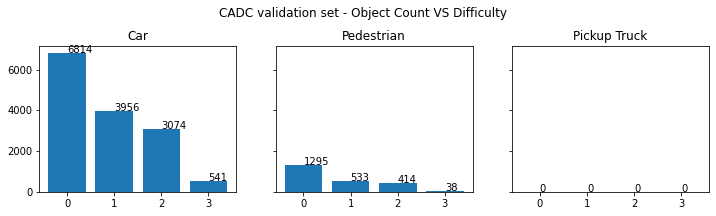

In [16]:
# Plot points in GT
car_list = []
car_list_dif = []
car_list_dist = []
ped_list = []
ped_list_dif = []
ped_list_dist = []
cyc_list = []
cyc_list_dif = []
cyc_list_dist = []
pickup_truck_list = []
pickup_truck_list_dif = []
pickup_truck_list_dist = []

def get_difficulty(occluded, truncated, height):
    MIN_HEIGHT = [40, 25, 25]
    MAX_OCCLUSION = [0, 1, 2]
    MAX_TRUNCATION = [0.15, 0.3, 0.5]

    # Mean is 19m, 40m
#     if height > MIN_HEIGHT[0]:
#         return 0
#     elif height > MIN_HEIGHT[1]:
#         return 1
#     elif height > 20:
#         return 2
#     else:
#         return 3

    if occluded <= MAX_OCCLUSION[0] and truncated <= MAX_TRUNCATION[0] and height > MIN_HEIGHT[0]:
        return 0
    elif occluded <= MAX_OCCLUSION[1] and truncated <= MAX_TRUNCATION[1] and height > MIN_HEIGHT[1]:
        return 1
    elif occluded <= MAX_OCCLUSION[2] and truncated <= MAX_TRUNCATION[2] and height > MIN_HEIGHT[2]:
        return 2
    else:
        return 3

for gt_dict in gt_dicts:
    for i in range(len(gt_dict['annos']['gt_boxes_lidar'])):
        if data_set_mode == 'kitti':
            difficulty = get_difficulty(gt_dict['annos']['occluded'][i],
                                            gt_dict['annos']['truncated'][i],
                                            gt_dict['annos']['bbox'][i][3] - gt_dict['annos']['bbox'][i][1])
        else:
            difficulty = get_difficulty(gt_dict['annos']['occluded'][i], 0.0, 50)
        dist = sqrt(gt_dict['annos']['gt_boxes_lidar'][i][0] ** 2 + gt_dict['annos']['gt_boxes_lidar'][i][1] ** 2)
        if gt_dict['annos']['name'][i] == 'Car':
            car_list.append(gt_dict['annos']['num_points_in_gt'][i])
            car_list_dif.append(difficulty)
            car_list_dist.append(dist)
        if gt_dict['annos']['name'][i] == 'Pedestrian':
            ped_list.append(gt_dict['annos']['num_points_in_gt'][i])
            ped_list_dif.append(difficulty)
            ped_list_dist.append(dist)
        if gt_dict['annos']['name'][i] == 'Cyclist':
            cyc_list.append(gt_dict['annos']['num_points_in_gt'][i])
            cyc_list_dif.append(difficulty)
            cyc_list_dist.append(dist)
        if gt_dict['annos']['name'][i] == 'Pickup_Truck':
            pickup_truck_list.append(gt_dict['annos']['num_points_in_gt'][i])
            pickup_truck_list_dif.append(difficulty)
            pickup_truck_list_dist.append(dist)
# difficulty_levels = [5, 20]
# chosen_list = np.array(ped_list)
# print('num objs', len(chosen_list))
# print('num objs with 0 points', sum(chosen_list == 0) )
# print('num objs with hard points', sum(np.logical_and(chosen_list > 0, chosen_list <= difficulty_levels[0])))
# print('num objs with med points', sum(np.logical_and(chosen_list > difficulty_levels[0], chosen_list <= difficulty_levels[1])))
# print('num objs with easy points', sum(chosen_list > difficulty_levels[1]))
# # the histogram of the data
# n, bins, patches = plt.hist(chosen_list, 1000)
# plt.xlabel('Number of Points')
# plt.ylabel('Count')
# plt.title('objs points')
# # plt.xlim(0, 100)
# plt.grid(True)
# plt.show()

if data_set_mode == 'kitti':
    chosen_list = [np.array(car_list), np.array(ped_list), np.array(cyc_list)]
    chosen_list_dif = [np.array(car_list_dif), np.array(ped_list_dif), np.array(cyc_list_dif)]
    chosen_list_dist = [np.array(car_list_dist), np.array(ped_list_dist), np.array(cyc_list_dist)]
else:
    chosen_list = [np.array(car_list), np.array(ped_list), np.array(pickup_truck_list)]
    chosen_list_dif = [np.array(car_list_dif), np.array(ped_list_dif), np.array(pickup_truck_list_dif)]
    chosen_list_dist = [np.array(car_list_dist), np.array(ped_list_dist), np.array(pickup_truck_list_dist)]

obj_data_list = []

for i in range(3):
    print('index', i)
    print('length objs', len(chosen_list[i]))
    
    print('bar graph')
    obj_data_list.append([len(chosen_list[i][chosen_list_dif[i] == 0]),
            len(chosen_list[i][chosen_list_dif[i] == 1]),
            len(chosen_list[i][chosen_list_dif[i] == 2]),
            len(chosen_list[i][chosen_list_dif[i] == 3])]
    )

#     print('min points for each difficulty')
#     print(np.min(chosen_list[i][chosen_list_dif[i] == 0]))
#     print(np.min(chosen_list[i][chosen_list_dif[i] == 1]))
#     print(np.min(chosen_list[i][chosen_list_dif[i] == 2]))
#     print(np.min(chosen_list[i][chosen_list_dif[i] == 3]))
#     print('mean points for each difficulty')
#     print(np.mean(chosen_list[i][chosen_list_dif[i] == 0]))
#     print(np.mean(chosen_list[i][chosen_list_dif[i] == 1]))
#     print(np.mean(chosen_list[i][chosen_list_dif[i] == 2]))
#     print(np.mean(chosen_list[i][chosen_list_dif[i] == 3]))

#     print('min distance for each difficulty')
#     print(np.min(chosen_list_dist[i][chosen_list_dif[i] == 0]))
#     print(np.min(chosen_list_dist[i][chosen_list_dif[i] == 1]))
#     print(np.min(chosen_list_dist[i][chosen_list_dif[i] == 2]))
#     print(np.min(chosen_list_dist[i][chosen_list_dif[i] == 3]))
#     print('mean distance for each difficulty')
#     print(np.mean(chosen_list_dist[i][chosen_list_dif[i] == 0]))
#     print(np.mean(chosen_list_dist[i][chosen_list_dif[i] == 1]))
#     print(np.mean(chosen_list_dist[i][chosen_list_dif[i] == 2]))
#     print(np.mean(chosen_list_dist[i][chosen_list_dif[i] == 3]))

#     print('graph')
#     fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#     fig2, axs2 = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

#     X = chosen_list_dist[i][chosen_list_dif[i] == 0]
#     y = chosen_list[i][chosen_list_dif[i] == 0]
#     axs[0].hist2d(X, y, bins=50, cmap='hot', cmax = 100)
#     axs2[0].scatter(X, y)

#     X = chosen_list_dist[i][chosen_list_dif[i] == 1]
#     y = chosen_list[i][chosen_list_dif[i] == 1]
#     axs[1].hist2d(X, y, bins=50, cmap='hot', cmax = 100)
#     axs2[1].scatter(X, y)

#     X = chosen_list_dist[i][chosen_list_dif[i] == 2]
#     y = chosen_list[i][chosen_list_dif[i] == 2]
#     axs[2].hist2d(X, y, bins=50, cmap='hot', cmax = 100)
#     axs2[2].scatter(X, y)

#     fig.suptitle('points vs distance')
#     fig2.suptitle('count objects at distance')

bar_fig, bar_axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
bar_fig.subplots_adjust(top=0.8)

if data_set_mode == 'kitti':
    class_names = ["Car", "Pedestrian", "Cyclist"]
    bar_fig.suptitle('KITTI validation set - Object Count VS Difficulty')
else:
    class_names = ["Car", "Pedestrian", "Pickup Truck"]
    bar_fig.suptitle('CADC validation set - Object Count VS Difficulty')

for i in range(3):
    bar_axs[i].bar([0,1,2,3], obj_data_list[i])
    bar_axs[i].set_title(class_names[i])
    for j,k in zip([0,1,2,3], obj_data_list[i]):
        bar_axs[i].annotate(str(k),xy=(j,k))

In [173]:
# Cluster pred_dicts
from cluster import cluster_preds

MIN_CLUSTER_SIZE = 1

print("Before clustering")
print("Number of frames", len(pred_dicts))
print("Number of pred dicts per frame", len(pred_dicts[0]))

if isinstance(pred_dicts[0], dict):
    print('No need to cluster')
else:
    print('Starting clustering')
    clustered_pred_dicts = cluster_preds(pred_dicts, data_set_mode, MIN_CLUSTER_SIZE)

    print("After clustering")
    print("Number of frames", len(clustered_pred_dicts))
    print("Is the output per frame now a single dict?", isinstance(clustered_pred_dicts[0], dict))

# import pickle

# pickle.dump( clustered_pred_dicts, open( 'pp_ensemble_clustered', "wb" ) )


  0%|          | 9/3769 [00:00<00:42, 88.78it/s]

Before clustering
Number of frames 3769
Number of pred dicts per frame 2
Starting clustering


100%|██████████| 3769/3769 [00:33<00:00, 114.15it/s]

After clustering
Number of frames 3769
Is the output per frame now a single dict? True


In [18]:
print(clustered_pred_dicts[0])

{'frame_id': '000001', 'seq_id': None, 'name': array(['Car', 'Car', 'Cyclist', 'Car', 'Car', 'Pedestrian', 'Car'],
      dtype='<U10'), 'pred_labels': array([1, 1, 3, 1, 1, 2, 1]), 'score': array([0.57280123, 0.3863098 , 0.2910245 , 0.19404039, 0.15297125,
       0.16171712, 0.1266502 ], dtype=float32), 'score_all': array([[5.72801232e-01, 2.98557978e-08, 2.98498790e-08, 4.27198768e-01],
       [3.86309803e-01, 2.97169969e-08, 2.97696392e-08, 6.13690138e-01],
       [5.33322861e-08, 5.33226086e-08, 2.91024506e-01, 7.08975315e-01],
       [1.94040388e-01, 2.14862439e-08, 2.14077502e-08, 8.05959523e-01],
       [1.52971253e-01, 1.60922173e-08, 1.60987810e-08, 8.47028792e-01],
       [4.78668127e-08, 1.61717117e-01, 4.78729056e-08, 8.38282764e-01],
       [1.26650214e-01, 1.45811896e-08, 1.45672745e-08, 8.73349845e-01]],
      dtype=float32), 'shannon_entropy': array([0.98465433, 0.96237828, 0.87004372, 0.70984872, 0.61722712,
       0.63840411, 0.54818008]), 'aleatoric_entropy': array([0

# Visualization


In [210]:
# Shared values
if data_set_mode == 'KITTI':
    xlim = [0, 69.12]
    ylim = [-30, 30]
    # Frame index to display (4, 5 is a good frame to check)
    idx = 6 # 4 # 100 # 5
    PLOT_IMG = True
elif data_set_mode == 'CADC':
    xlim = [-50, 50]
    ylim = [-50, 50]
    idx = 1021
    PLOT_IMG = True
elif data_set_mode == 'NuScenes':
    xlim = [-50, 50]
    ylim = [-50, 50]
    idx = 0
    PLOT_IMG = False

scale = 0.32

# 1. View only GT

GT frame_id 000015


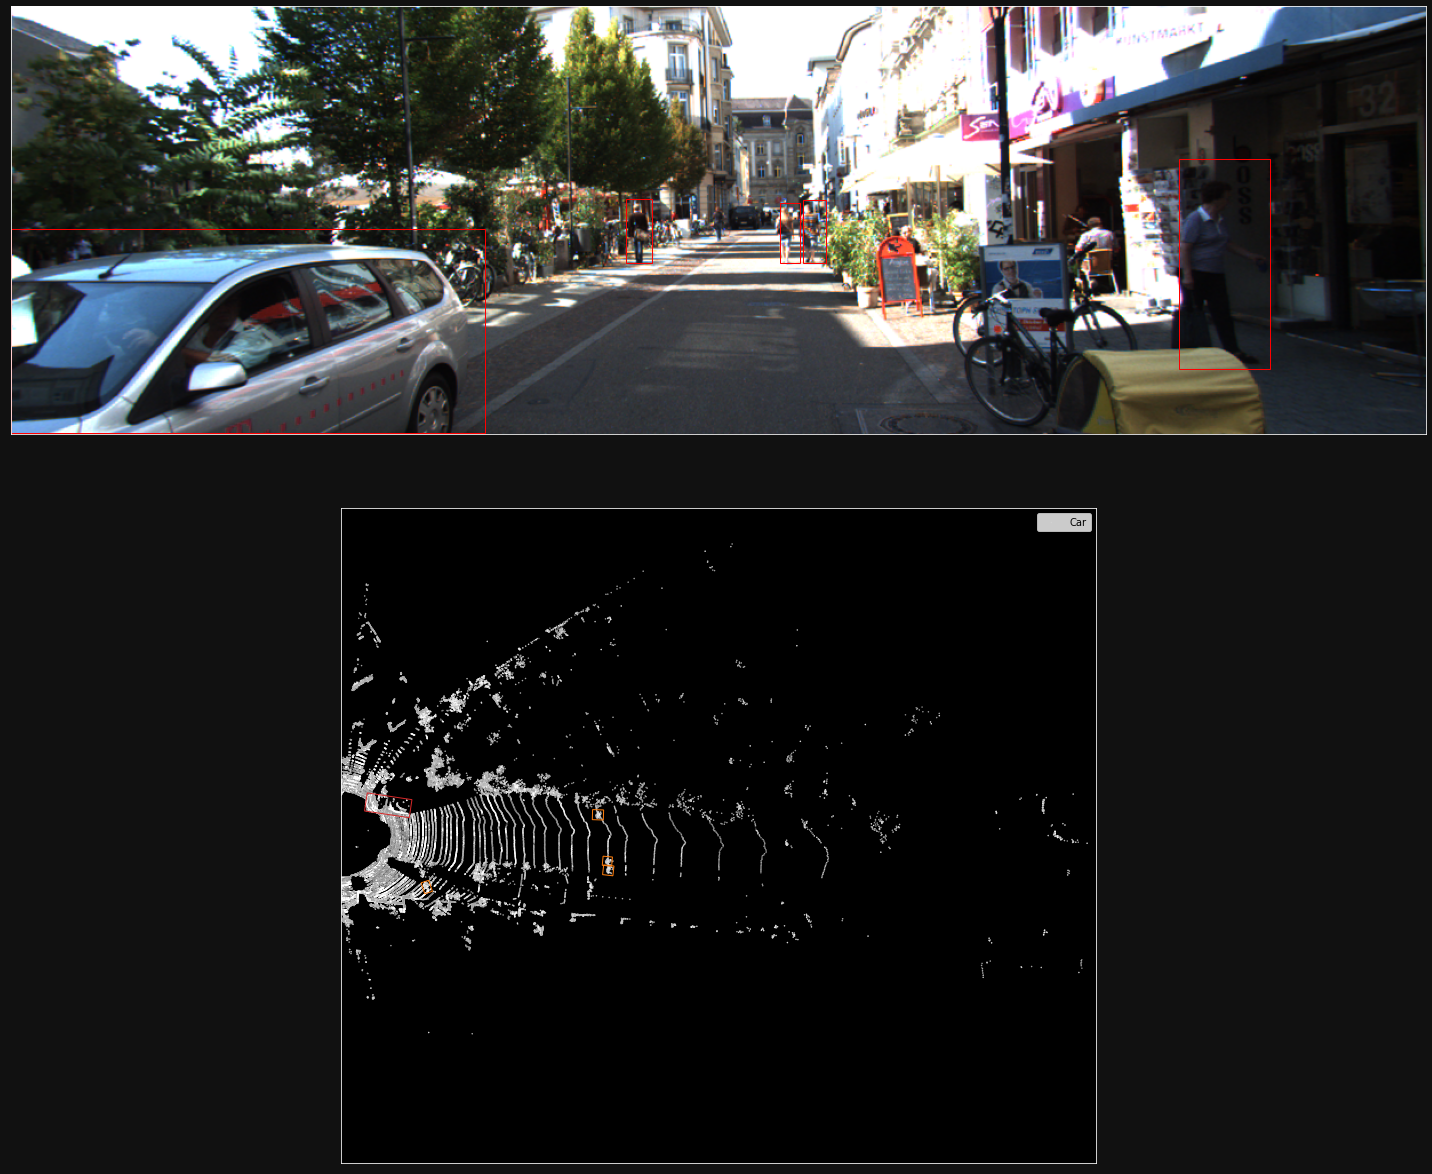

In [211]:
gt_dict = gt_dicts[idx]
# for i in range(len(gt_dicts)):
#     if gt_dicts[i]['point_cloud']['lidar_idx'] == '000267':
#         gt_dict = gt_dicts[i]
#         break
# print(gt_dict['annos'])
# for i in range(len(gt_dict['annos']['gt_boxes_lidar'])):
#     if gt_dict['annos']['gt_boxes_lidar'][i][0] < 0: # behind vehicle
#         continue
#     print('gt object:')
#     print('lidar z', gt_dict['annos']['gt_boxes_lidar'][i][2])
#     print('lidar height', gt_dict['annos']['gt_boxes_lidar'][i][5])
#     print('camera y', gt_dict['annos']['location'][i][1])
#     print('camera dimensions', gt_dict['annos']['dimensions'][i])
if data_set_mode == 'KITTI':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Cyclist': 3 }
    points = load_lidar(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image(gt_dict['image']['image_idx'])
    print('GT frame_id', gt_dict['image']['image_idx'])
elif data_set_mode == 'CADC':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Pickup_Truck': 3 }
    points = load_lidar_cadc(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image_cadc(gt_dict['image']['image_idx'])
elif data_set_mode == 'NuScenes':
    gt_dict = {
        'lidar_path': gt_dict['lidar_path'],
        'annos': {
            'name': gt_dict['gt_names'],
            'gt_boxes_lidar': gt_dict['gt_boxes'][..., :7],
            'num_points_in_gt': gt_dict['num_lidar_pts'] + gt_dict['num_radar_pts']
            
        }
    }
    name_to_label = { 'car': 1, 'truck':2, 'construction_vehicle':3, 'bus':4, 'trailer':5, \
               'barrier':6, 'motorcycle':7, 'bicycle':8, 'pedestrian':9, 'traffic_cone':10}
    points = load_lidar_nuscenes(gt_dict['lidar_path'], xlim, ylim)

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

if PLOT_IMG:
    ax = plt.subplot(211)
    for name, box, bbox in zip(gt_dict['annos']['name'], gt_dict['annos']['gt_boxes_lidar'], gt_dict['annos']['bbox']):
        if box[0] < 0: # behind vehicle
            continue
        # Create a Rectangle patch
        rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=1.0, c=points[:,3], cmap='binary')

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']

if data_set_mode == 'KITTI':
    ax.legend(('Car', 'Pedestrian', 'Cyclist'))
    for name, box in zip(gt_dict['annos']['name'], gt_dict['annos']['gt_boxes_lidar']):
        if name in name_to_label:
            label = name_to_label[name]
            add_box(ax, box, color=class_colors[label])
elif data_set_mode == 'CADC':
    ax.legend(('Car', 'Pedestrian', 'Pickup_Truck'))
    for name, box, num_points in zip(gt_dict['annos']['name'], gt_dict['annos']['gt_boxes_lidar'], gt_dict['annos']['num_points_in_gt']):
        if name in name_to_label:
            label = name_to_label[name]
            add_box(ax, box, color=class_colors[label])
            add_text(ax, box, num_points, color=class_colors[label])
elif data_set_mode == 'NuScenes':
    ax.legend(('car','truck', 'construction_vehicle', 'bus', 'trailer', \
               'barrier', 'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'))
    class_colors = ['tab:gray', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
                    'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red']
    for name, box, num_points in zip(gt_dict['annos']['name'], gt_dict['annos']['gt_boxes_lidar'], gt_dict['annos']['num_points_in_gt']):
        if name in name_to_label:
            label = name_to_label[name]
            add_box(ax, box, color=class_colors[label])
            add_text(ax, box, num_points, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 2. View outputs from all forward passes

PRED frame_id 000015
PRED frame_id 000015


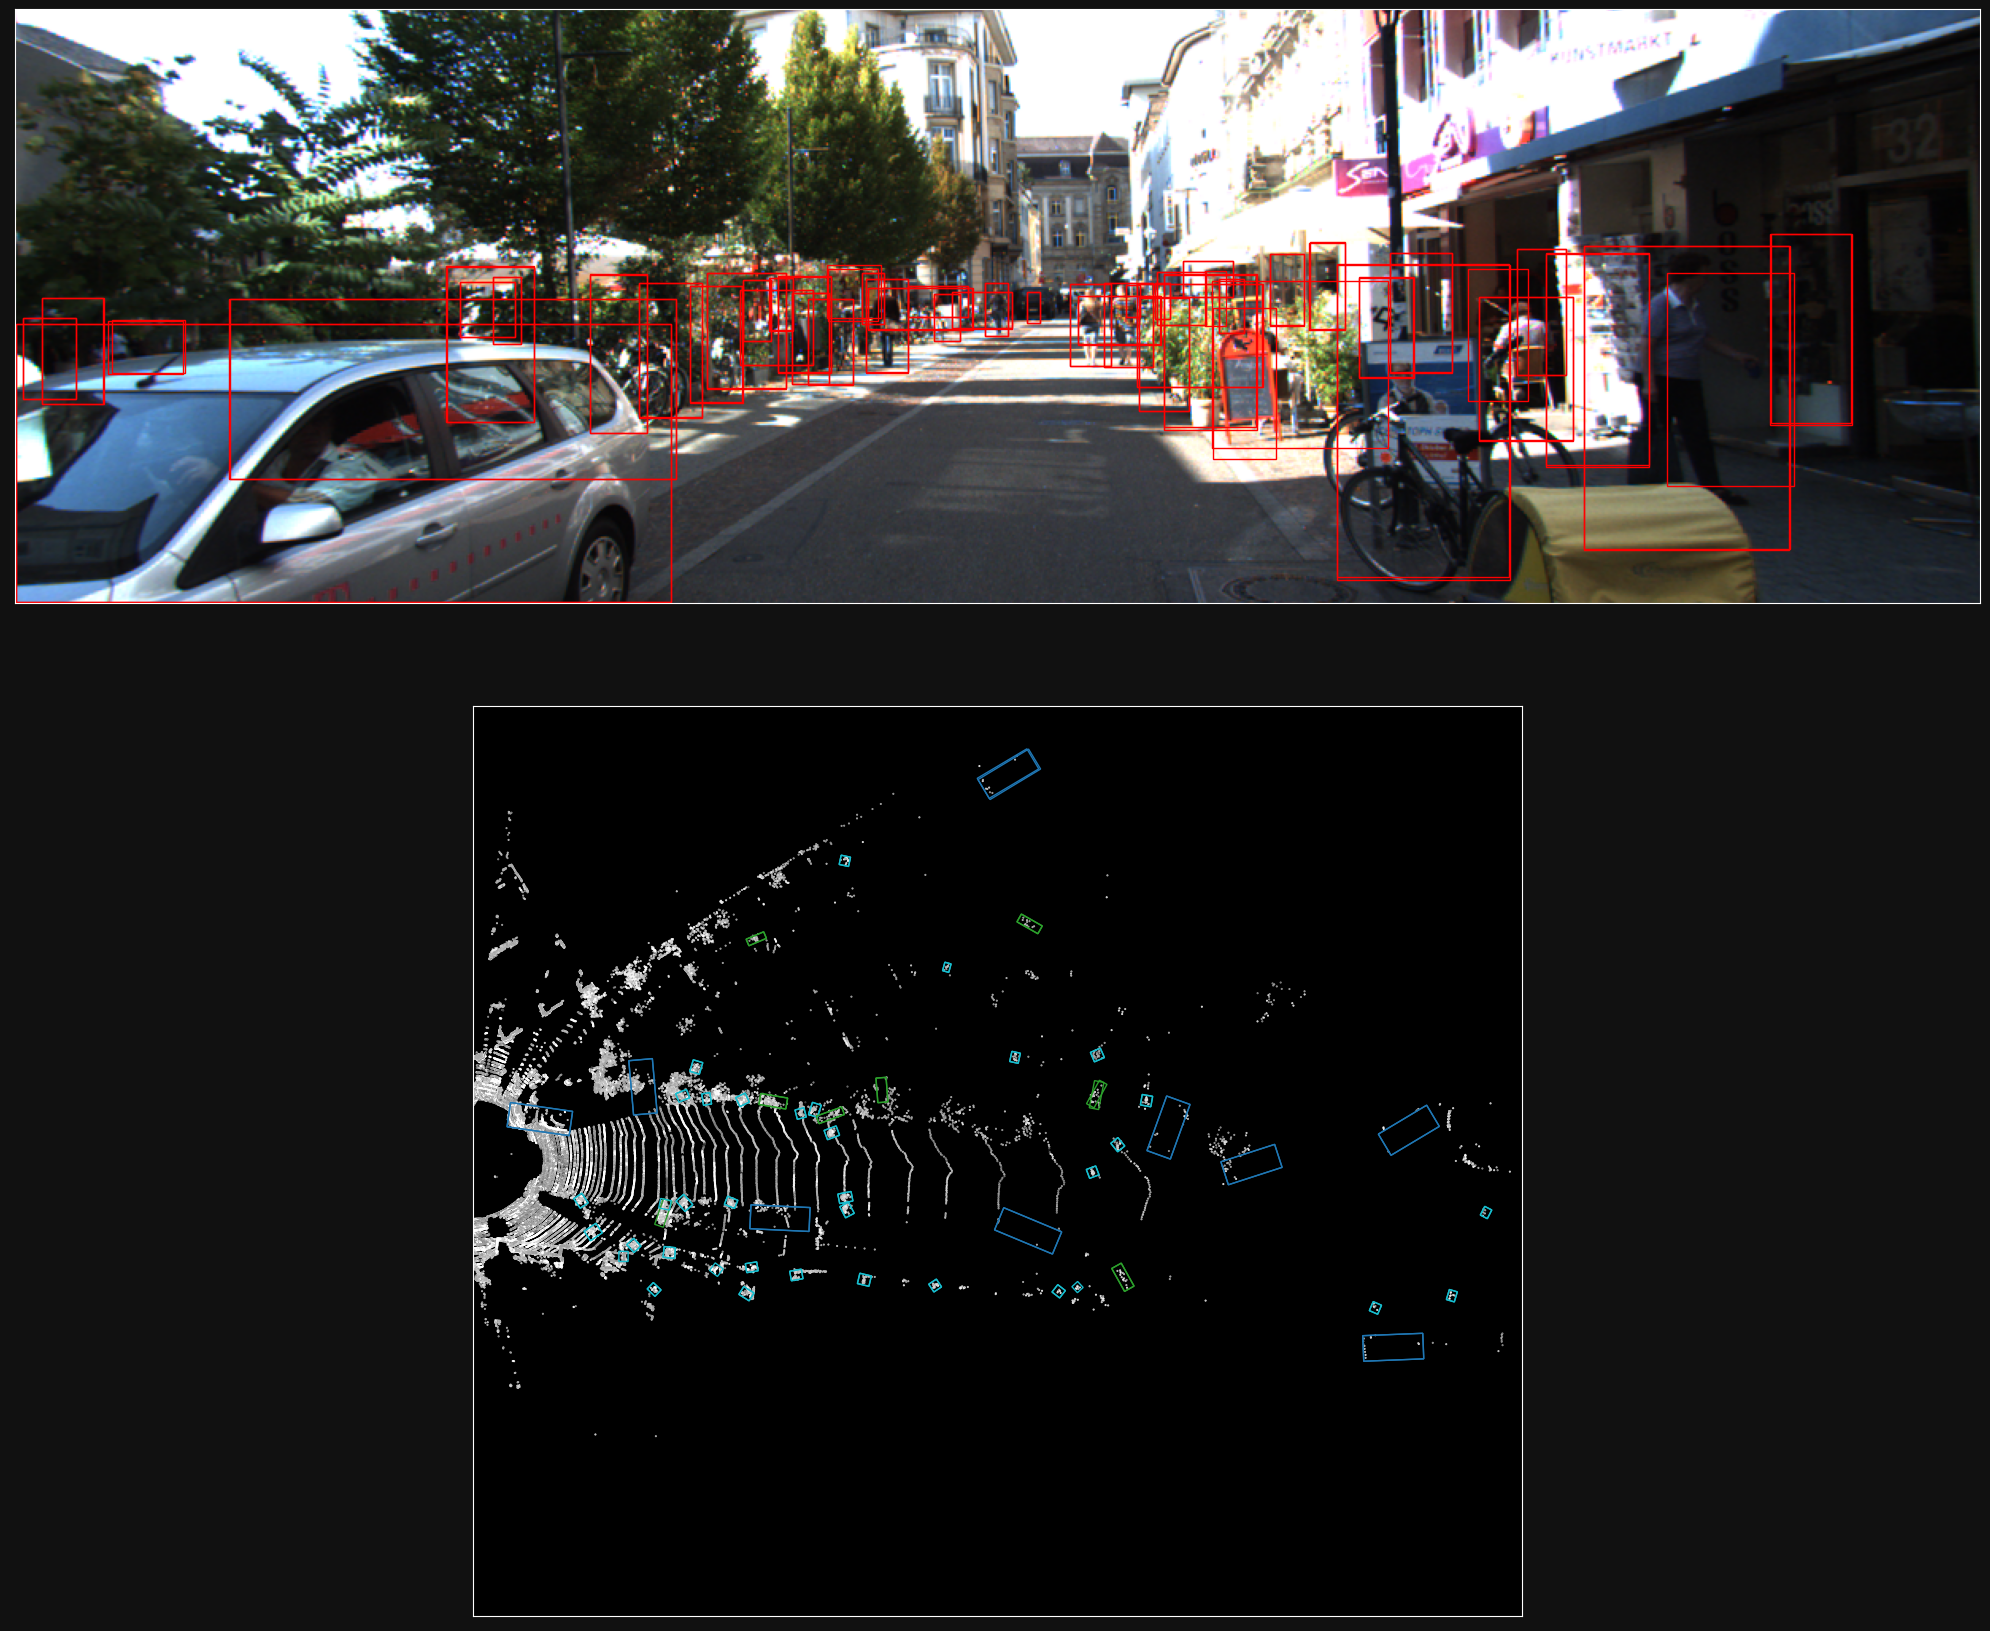

In [212]:
gt_dict = gt_dicts[idx]
pred_dict = copy.deepcopy(pred_dicts[idx])
if data_set_mode == 'kitti':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Cyclist': 3 }
    points = load_lidar(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image(gt_dict['image']['image_idx'])
elif data_set_mode == 'cadc':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Pickup_Truck': 3 }
    points = load_lidar_cadc(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image_cadc(gt_dict['image']['image_idx'])
elif data_set_mode == 'nuscenes':
    name_to_label = { 'car': 1, 'truck':2, 'construction_vehicle':3, 'bus':4, 'trailer':5, \
               'barrier':6, 'motorcycle':7, 'bicycle':8, 'pedestrian':9, 'traffic_cone':10}
    points = load_lidar_nuscenes(gt_dict['lidar_path'], xlim, ylim)

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067), dpi=100)

if PLOT_IMG:
    ax = plt.subplot(211)
    if NETWORK_VAR_AVAILABLE:
        for single_pred_dict in pred_dict:
            print('PRED frame_id', single_pred_dict['frame_id'])
            for name, box, bbox in zip(single_pred_dict['name'], single_pred_dict['boxes_lidar'], single_pred_dict['bbox']):
                if box[0] < 0: # behind vehicle
                    continue
                # Create a Rectangle patch
                rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect)
    else:
        for name, box, bbox in zip(pred_dict['name'], pred_dict['boxes_lidar'], pred_dict['bbox']):
            if box[0] < 0: # behind vehicle
                continue
            # Create a Rectangle patch
            rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=1.0, c=points[:,3], cmap='binary')

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']

if data_set_mode == 'kitti':
    ax.legend(('Car', 'Pedestrian', 'Cyclist'))
elif data_set_mode == 'cadc':
    ax.legend(('Car', 'Pedestrian', 'Pickup_Truck'))
elif data_set_mode == 'nuscenes':
    ax.legend(('car','truck', 'construction_vehicle', 'bus', 'trailer', \
           'barrier', 'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'))
    class_colors = ['tab:gray', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
                    'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red']

# Display all pred_dicts for a frame
if NETWORK_VAR_AVAILABLE:
    prediction_head_colors = ['tab:blue', 'tab:green']
    count = 0
    for single_pred_dict in pred_dict:
        for label, box, box_vars in zip(np.argmax(single_pred_dict['score_all'][:,:-1], axis=-1)+1,
                                        single_pred_dict['boxes_lidar'], single_pred_dict['pred_vars']):
            box_copy = copy.deepcopy(box)
            box_copy[2] += box_copy[5]/2
#             add_box_vars(ax, box_copy, box_vars, cluster_size=1, color=class_colors[label])
            add_box(ax, box_copy, color=class_colors[label])
#             add_box(ax, box_copy, color=prediction_head_colors[count])
        count += 1
else:
    for name, box in zip(pred_dict['name'], pred_dict['boxes_lidar']):
        label = name_to_label[name]
        add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 3. View clustered output

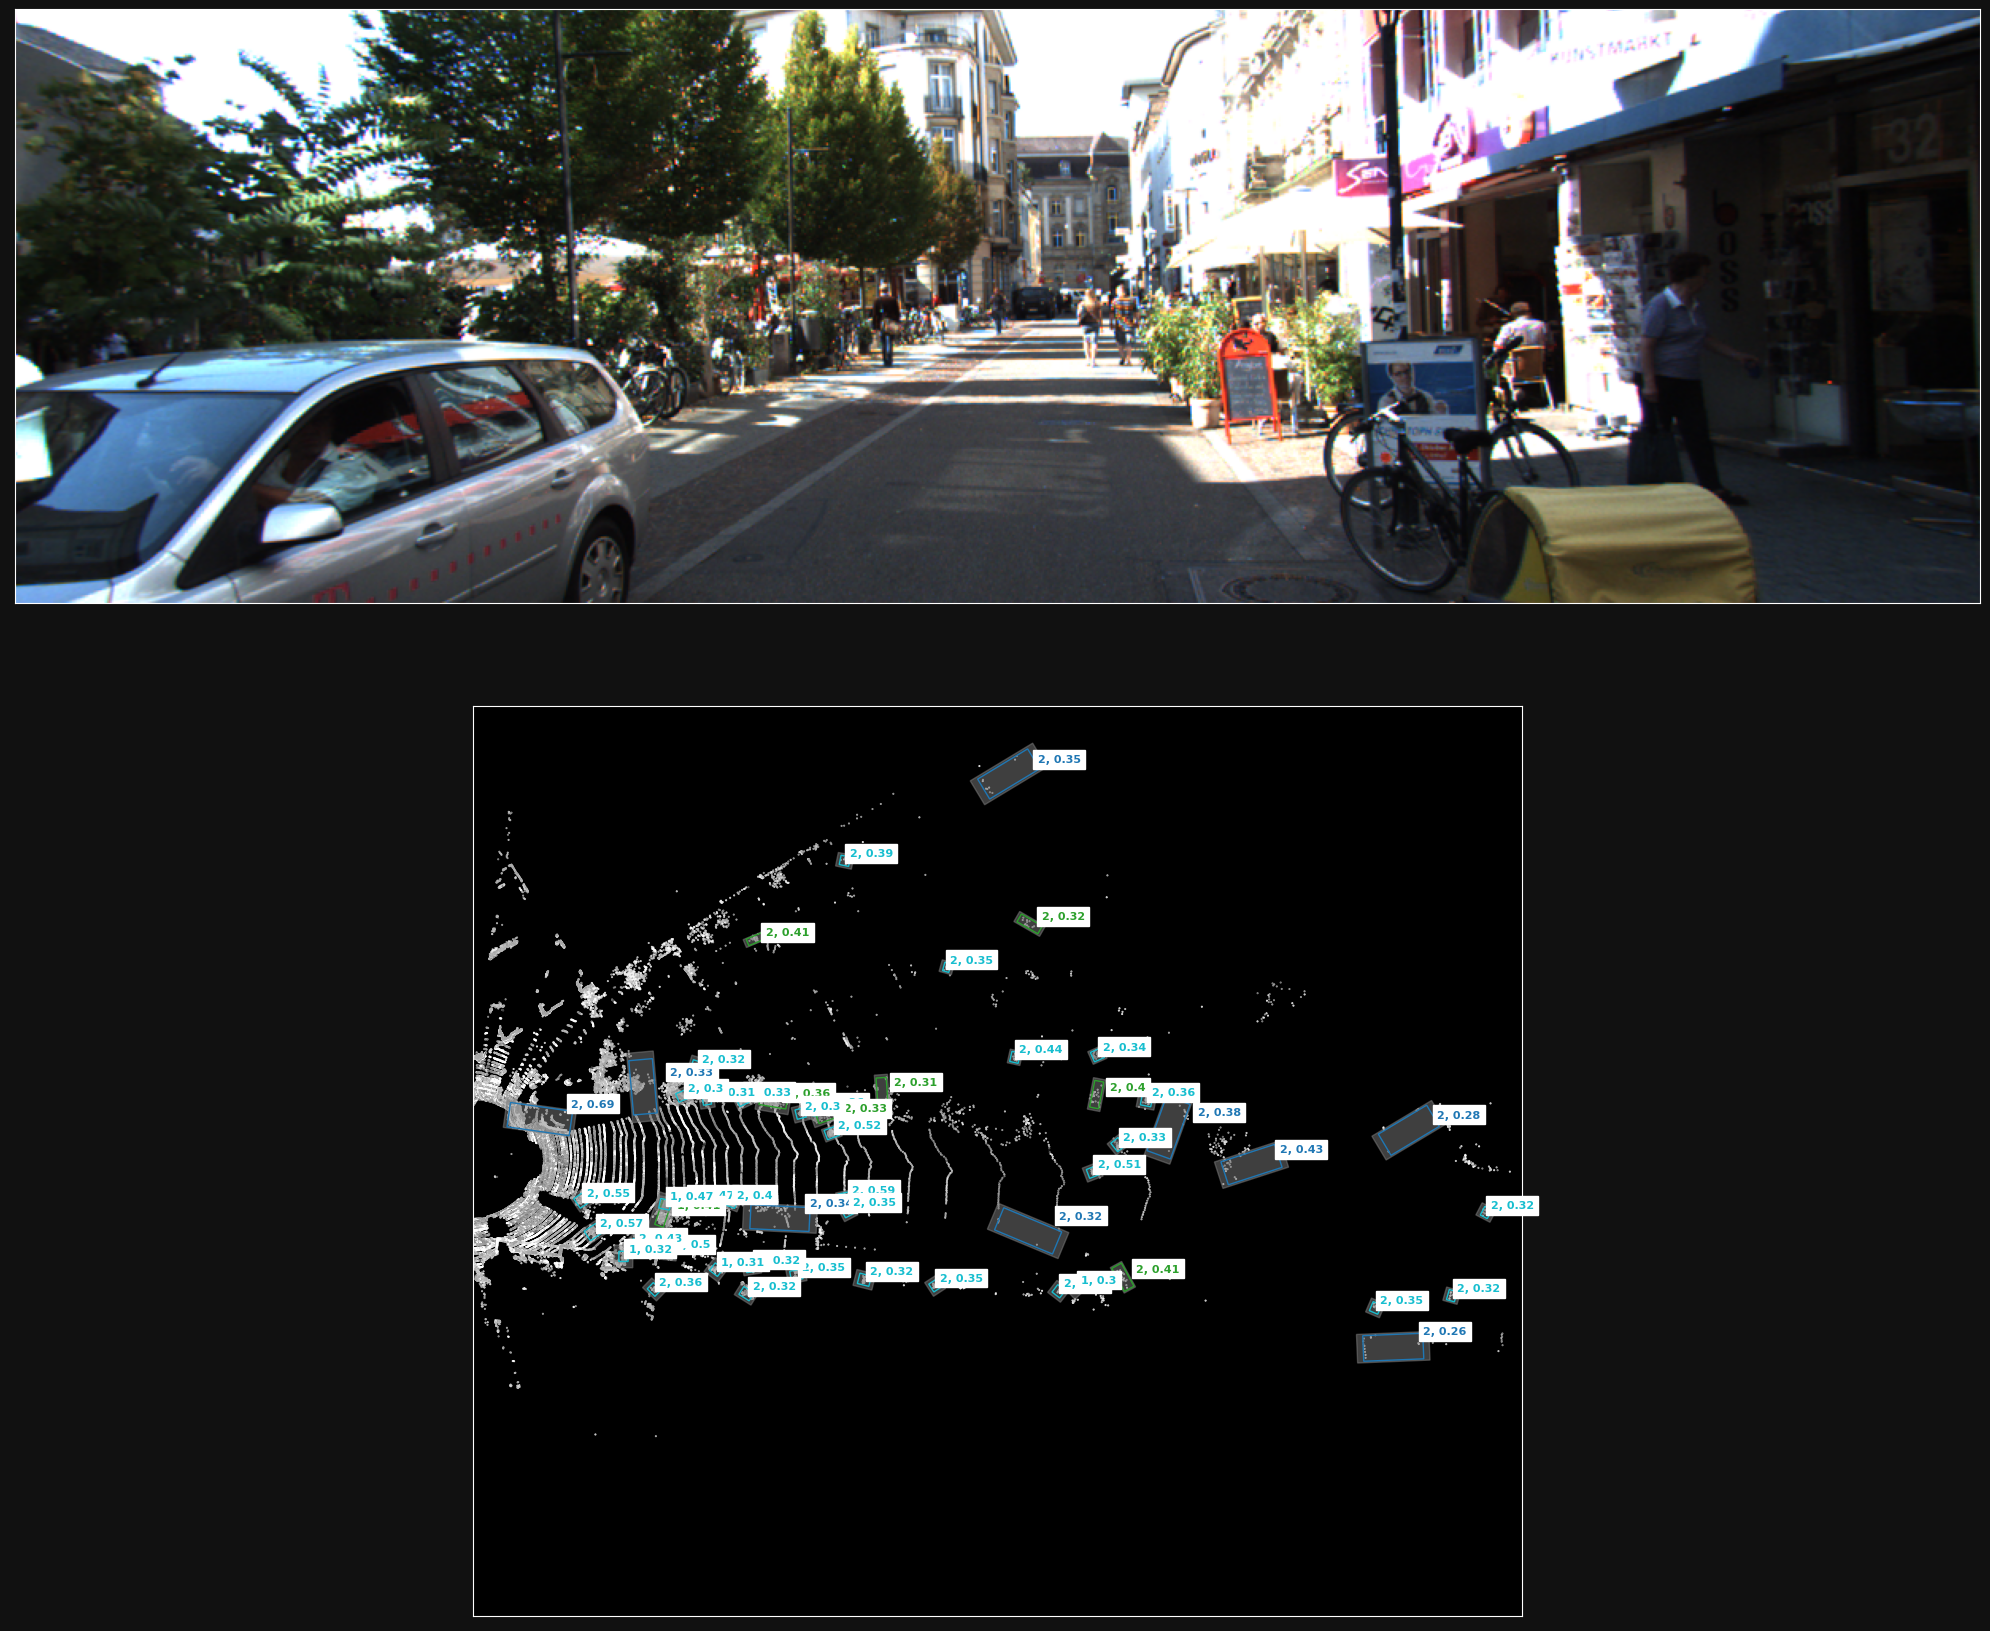

In [213]:
gt_dict = gt_dicts[idx]
pred_dict = copy.deepcopy(clustered_pred_dicts[idx])
if data_set_mode == 'kitti':
    points = load_lidar(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image(gt_dict['image']['image_idx'])
elif data_set_mode == 'cadc':
    points = load_lidar_cadc(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image_cadc(gt_dict['image']['image_idx'])
elif data_set_mode == 'nuscenes':
#     tmp_dim = copy.deepcopy(pred_dict['boxes_lidar'][..., 3])
#     pred_dict['boxes_lidar'][..., 3] = copy.deepcopy(pred_dict['boxes_lidar'][..., 4])
#     pred_dict['boxes_lidar'][..., 4] = tmp_dim
    name_to_label = { 'car': 1, 'truck':2, 'construction_vehicle':3, 'bus':4, 'trailer':5, \
               'barrier':6, 'motorcycle':7, 'bicycle':8, 'pedestrian':9, 'traffic_cone':10}
    points = load_lidar_nuscenes(gt_dict['lidar_path'], xlim, ylim)

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067), dpi=100)

if PLOT_IMG:
    ax = plt.subplot(211)
    plt.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=1.0, c=points[:,3], cmap='binary')

# For KITTI and CADC
class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']

if data_set_mode == 'kitti':
    ax.legend(('Car', 'Pedestrian', 'Cyclist'))
elif data_set_mode == 'cadc':
    ax.legend(('Car', 'Pedestrian', 'Pickup_Truck'))
elif data_set_mode == 'nuscenes':
    ax.legend(('car','truck', 'construction_vehicle', 'bus', 'trailer', \
           'barrier', 'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'))
    class_colors = ['tab:gray', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
                    'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red']

for softmax, box, box_vars, cluster_size in zip(pred_dict['score_all'],
                                pred_dict['boxes_lidar'], pred_dict['pred_vars'],
                                pred_dict['cluster_size']):
    label = np.argmax(softmax[:-1])+1
    score = softmax[np.argmax(softmax[:-1])].round(2)
    add_box_vars(ax, box, box_vars, cluster_size=cluster_size, color=class_colors[label])
    add_box(ax, box, color=class_colors[label])
    add_text(ax, box, str(cluster_size) + ', ' + str(score), color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 4. View GT and clustered output

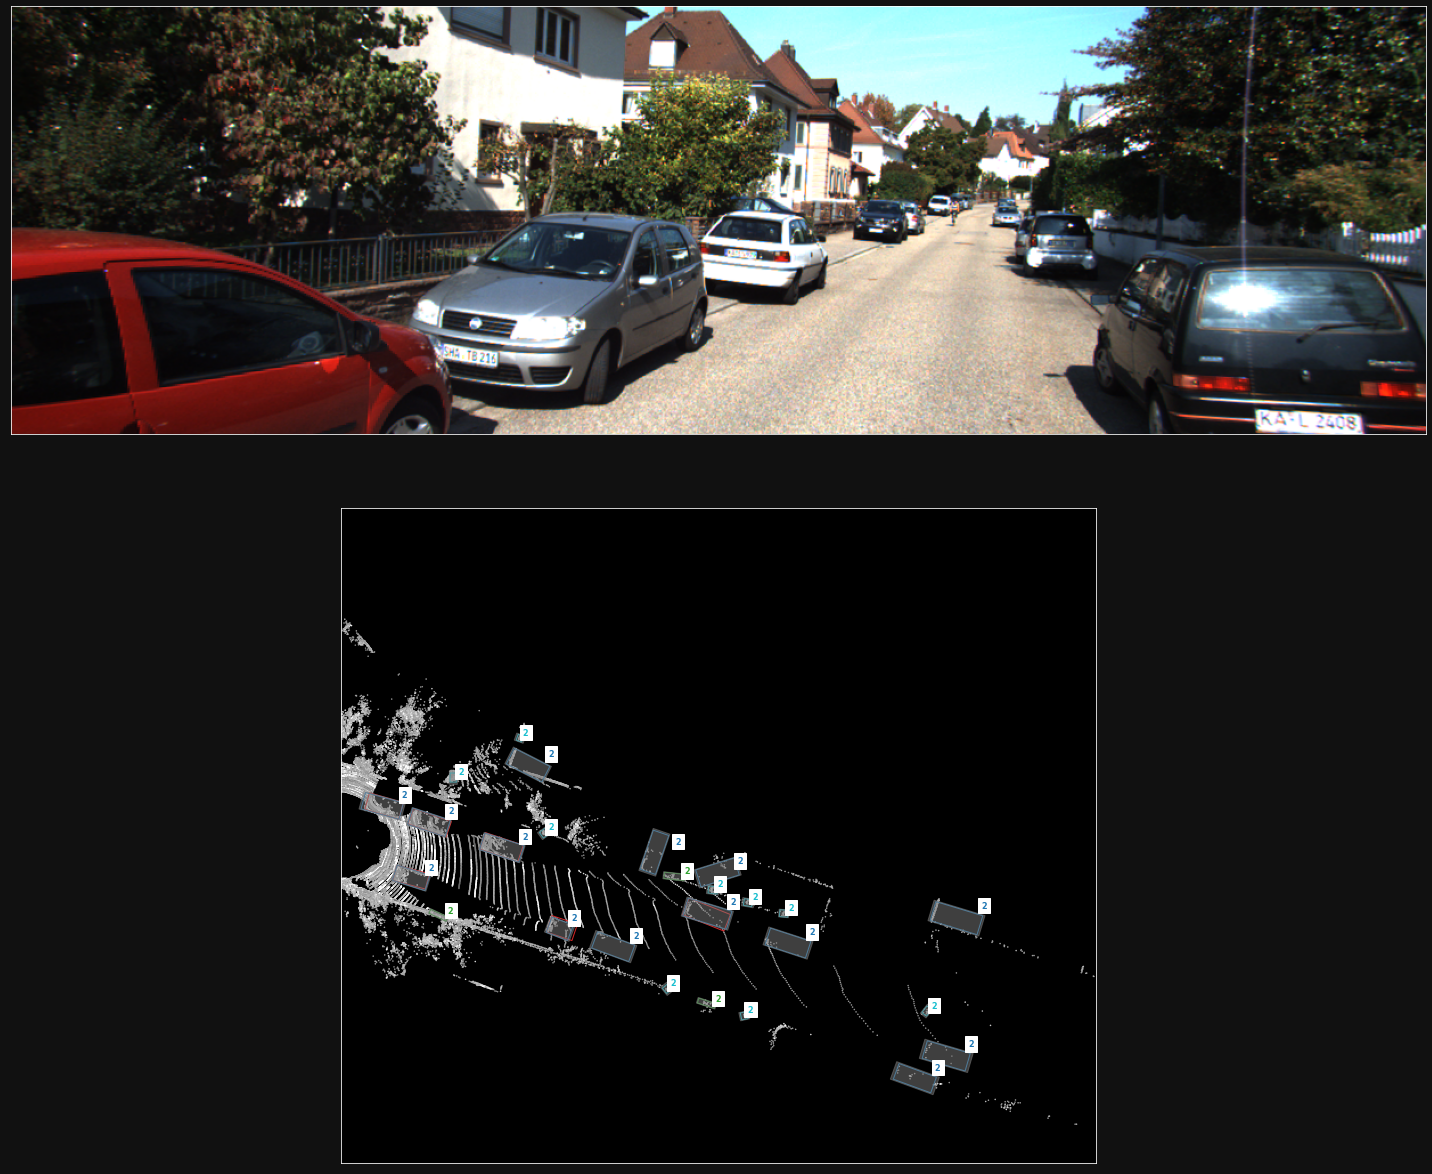

In [208]:
gt_dict = gt_dicts[idx]
pred_dict = clustered_pred_dicts[idx]
if data_set_mode == 'kitti':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Cyclist': 3 }
    points = load_lidar(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image(gt_dict['image']['image_idx'])
elif data_set_mode == 'cadc':
    name_to_label = { 'Car': 1, 'Pedestrian': 2, 'Pickup_Truck': 3 }
    points = load_lidar_cadc(gt_dict['image']['image_idx'], xlim, ylim)
    image = load_image_cadc(gt_dict['image']['image_idx'])

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=1.0, c=points[:,3], cmap='binary')

if data_set_mode == 'kitti':
    ax.legend(('Car', 'Pedestrian', 'Cyclist'))
elif data_set_mode == 'cadc':
    ax.legend(('Car', 'Pedestrian', 'Pickup_Truck'))

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']
for name, box in zip(gt_dict['annos']['name'], gt_dict['annos']['gt_boxes_lidar']):
    if name in name_to_label:
        label = name_to_label[name]
        add_box(ax, box, color=class_colors[label])

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']

if NETWORK_VAR_AVAILABLE:
    for label, box, box_vars, cluster_size in zip(np.argmax(single_pred_dict['score_all'][:,:-1], axis=-1)+1,
                                    single_pred_dict['boxes_lidar'], single_pred_dict['pred_vars'],
                                    pred_dict['cluster_size']):
        add_box(ax, box, color=class_colors[label])
        add_box_vars(ax, box, box_vars, cluster_size=cluster_size, color=class_colors[label])
        add_text(ax, box, cluster_size, color=class_colors[label])
else:
    for name, box in zip(pred_dict['name'], pred_dict['boxes_lidar']):
        label = name_to_label[name]
        add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()